In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import coint
from scipy.stats import linregress
import seaborn as sns

In [101]:
JPM = yf.download("JPM", start="2024-04-19", end="2024-04-20", interval="1m")
BAC = yf.download("BAC", start="2024-04-19", end="2024-04-20", interval="1m")

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


In [102]:
common_indexes = JPM.index.intersection(BAC.index)
JPM = JPM.loc[common_indexes]
BAC = BAC.loc[common_indexes]
JPM.shape, BAC.shape

((390, 6), (390, 6))

In [103]:
p1 = JPM['Adj Close']
p2 = BAC['Adj Close']
p1.iloc[0], p2.iloc[0]

(181.90499877929688, 36.13999938964844)

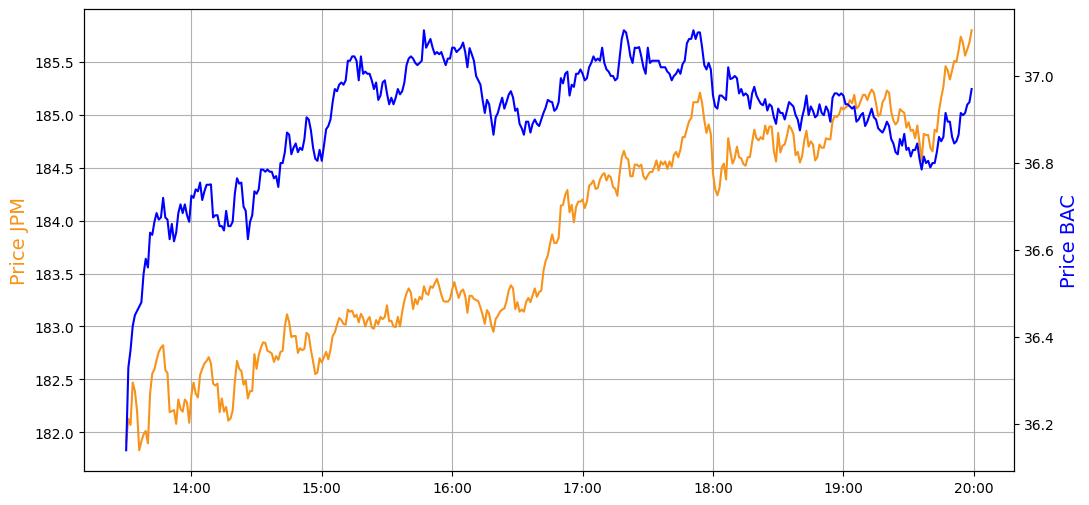

In [104]:
# Define the figure size (width, height) in inches
fig, ax1 = plt.subplots(figsize=(12, 6))  # Adjust the width (12 inches) to make it wider

# Plot price_JPM on the left y-axis
ax1.plot(JPM.index, p1, color='#f7931a')
ax1.set_ylabel('Price JPM', color='#f7931a', fontsize=14)

# Create a twin y-axis for price_BAC
ax2 = ax1.twinx()

# Plot price_BAC on the right y-axis
ax2.plot(BAC.index, p2, color='blue')
ax2.set_ylabel('Price BAC', color='blue', fontsize=14)

# Format the x-axis ticks to show only the hours
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.grid(True)
plt.show()

In [105]:
r_JPM = np.log(p1 / p1.shift(1)).dropna()
r_BAC = np.log(p2 / p2.shift(1)).dropna()

In [106]:
rho = r_JPM.corr(r_BAC, method='pearson')
print(f'Correlation between JPM and BAC: {rho.round(4)}')

Correlation between JPM and BAC: 0.6729


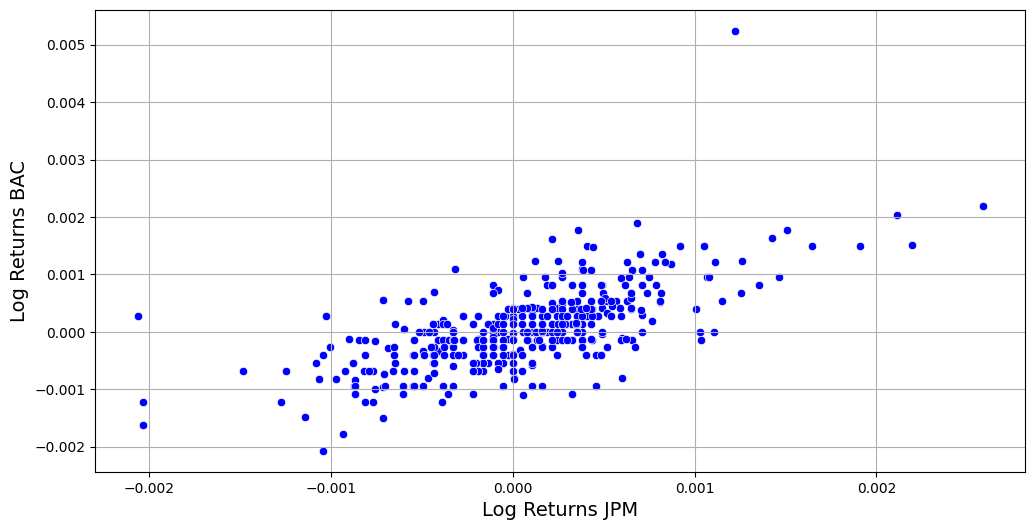

In [107]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=r_JPM, y=r_BAC, color='blue')
plt.xlabel('Log Returns JPM', fontsize=14)
plt.ylabel('Log Returns BAC', fontsize=14)
# plt.title('Scatter Plot of Log Returns', fontsize=16)
plt.grid(True)
plt.show()

Beta: 0.3541


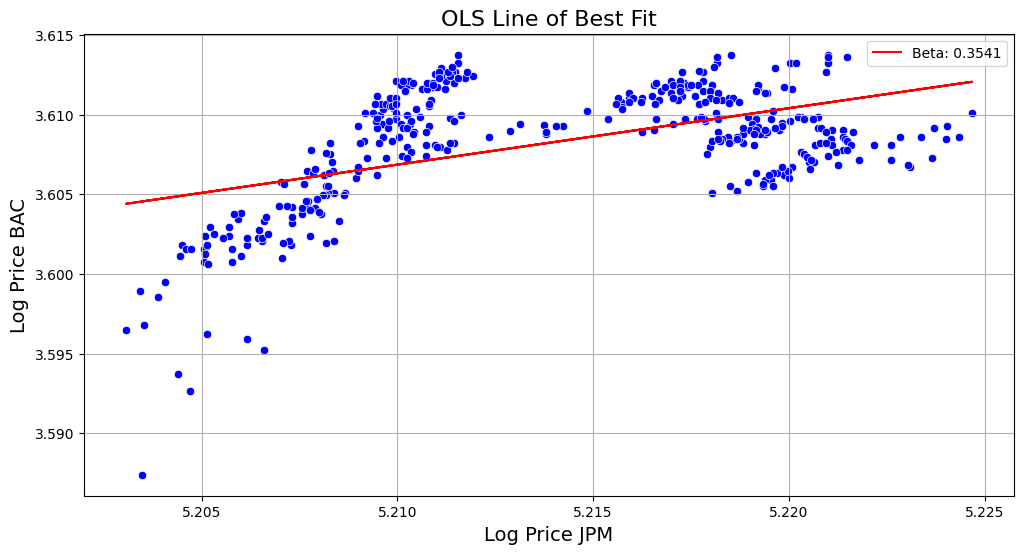

In [108]:
slope, intercept, r_value, p_value, std_err = linregress(np.log(p1), np.log(p2))

beta = slope
print(f'Beta: {beta:.4f}')

plt.figure(figsize=(12, 6))
sns.scatterplot(x=np.log(p1), y=np.log(p2), color='blue')
plt.plot(np.log(p1), beta * np.log(p1) + intercept, color='red', label=f'Beta: {beta:.4f}')
plt.xlabel('Log Price JPM', fontsize=14)
plt.ylabel('Log Price BAC', fontsize=14)
plt.title('OLS Line of Best Fit', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

In [109]:
S1_0 = JPM['Open'].iloc[0]
S2_0 = BAC['Open'].iloc[0]
mu_1 = r_JPM.mean()*len(JPM)
mu_2 = r_BAC.mean()*len(JPM)
sigma_1 = r_JPM.std()*np.sqrt(len(JPM))
sigma_2 = r_BAC.std()*np.sqrt(len(JPM))
z_0 = 0

In [110]:
print(f'S1_0: {S1_0:.4f}')
print(f'S2_0: {S2_0:.4f}')
print(f'mu_1: {mu_1:.4f}')
print(f'mu_2: {mu_2:.4f}')
print(f'sigma_1: {sigma_1:.4f}')
print(f'sigma_2: {sigma_2:.4f}')

S1_0: 182.4000
S2_0: 36.1000
mu_1: 0.0212
mu_2: 0.0228
sigma_1: 0.0116
sigma_2: 0.0140


In [111]:
gamma = 0.5
delta = 1
T = 1
M = len(p1)

In [112]:
dt = T / M
S1 = np.zeros((M + 1,  1))
S2 = np.zeros((M + 1,  1))
z = np.zeros((M + 1,  1))
a = np.zeros((M + 1, 1))
b = np.zeros((M + 1, 1))
c = np.zeros((M + 1, 1))
pi_1 = np.zeros((M + 1, 1))
pi_2 = np.zeros((M + 1, 1))
tt = np.linspace(0, 1, M + 1)
z[0] = z_0
S1[0] = S1_0
S2[0] = S2_0
sigma_beta = np.sqrt(sigma_1 ** 2 + beta ** 2 * sigma_2 ** 2 + 2 * beta * sigma_1 * sigma_2 * rho)
eta = (-1/delta) * (mu_1 - sigma_1 ** 2/2 + beta*(mu_2 - sigma_2 ** 2/2))
B_t = np.random.standard_normal(z.shape)
B1 = np.random.standard_normal(S1.shape) 
B2 = np.random.standard_normal(S2.shape) 
for t in range(1, M + 1):
    z[t] = z[t-1]* (1 - delta * (eta - z[t-1])) * dt + sigma_beta * np.sqrt(dt)*((sigma_1 + beta * sigma_2 * rho)/ sigma_beta * B1[t] + beta * (sigma_2 * np.sqrt(1-rho ** 2)/sigma_beta) * B1[t]);
    S1[t] = S1[t-1] * np.exp((mu_1 + delta * z[t] - sigma_1 ** 2 / 2) * dt + sigma_1 * np.sqrt(dt) * B1[t])
    S2[t] = S2[t-1] * np.exp((mu_2 - sigma_2 ** 2 / 2) * dt + sigma_2 * np.sqrt(dt) * (rho * B1[t] + np.sqrt(1 - rho ** 2) * B2[t]))

Text(0.5, 1.0, 'z')

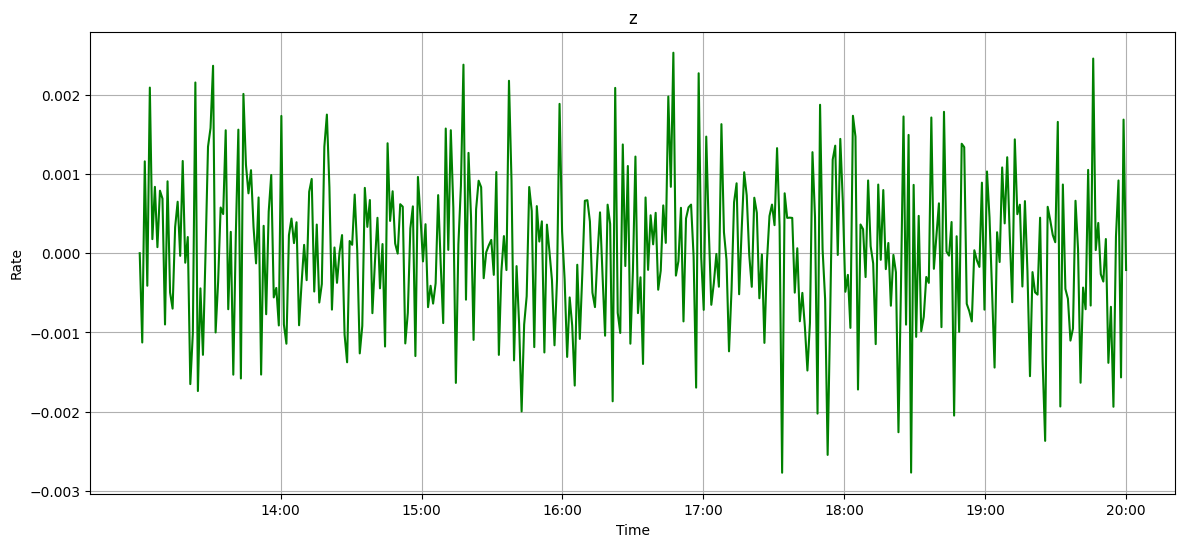

In [113]:
plt.figure(figsize=(14, 6))
plt.plot(tt, z, 'g', lw=1.5)
plt.xlabel('Time')
plt.ylabel('Rate')
plt.grid(True)
plt.xticks(ticks = [ 0.1428571429, 0.1428571429*2, 0.1428571429*3, 0.1428571429*4, 0.1428571429*5, 0.1428571429*6, 0.1428571429*7], labels=['14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00'])
plt.title('z')

In [114]:
for t in range(1, M + 1):
    a[t] = 0.5 * (T - t * dt)/((1-rho ** 2) * sigma_1 ** 2)
    b[t] = - 0.25 * (T - t * dt) ** 2 * (sigma_1 ** 2 + beta * sigma_2 ** 2)/((1 - rho ** 2) * sigma_1 ** 2) - rho * mu_2 * (T - t * dt)/((1 - rho **2) * sigma_1 * sigma_2)
    c[t] = 0.5 * mu_2 ** 2 * (T - t * dt)/((1 - rho ** 2) * sigma_2 ** 2) + 0.25 * (T - t * dt) ** 2 * (sigma_1 ** 2 + beta * sigma_2 ** 2 + 2 * sigma_1 * sigma_2 * beta *rho) * delta ** 2/((1 - rho ** 2) * sigma_1 ** 2) + 0.25 * (T - t * dt) ** 2 * mu_2 * delta * rho * (sigma_1 ** 2 + beta * sigma_2 ** 2) + 1/24 * (T - t * dt) ** 3 * (sigma_1 ** 2 + beta * sigma_2 ** 2) ** 2 * delta ** 2/((1 - rho ** 2) * sigma_1 ** 2)
    pi_1[t] = (1 / S1[t]) * ((mu_1 + delta * z[t])/(gamma * (1 - rho ** 2) * sigma_1 ** 2) + delta/gamma * (-2 * a[t] * (mu_1 + delta * z[t])-b[t]) - rho * mu_2/(gamma * (1 - rho ** 2) * sigma_1 * sigma_2))
    pi_2[t] = (1 / S2[t]) * (mu_2 / (gamma * (1 - rho ** 2) * sigma_2 ** 2) + delta * beta / gamma * (- 2 * a[t] * (mu_1 + delta * z[t]) - b[t]) - rho * (mu_1 + delta * z[t]) / (gamma * (1 - rho ** 2) * sigma_1 * sigma_2))

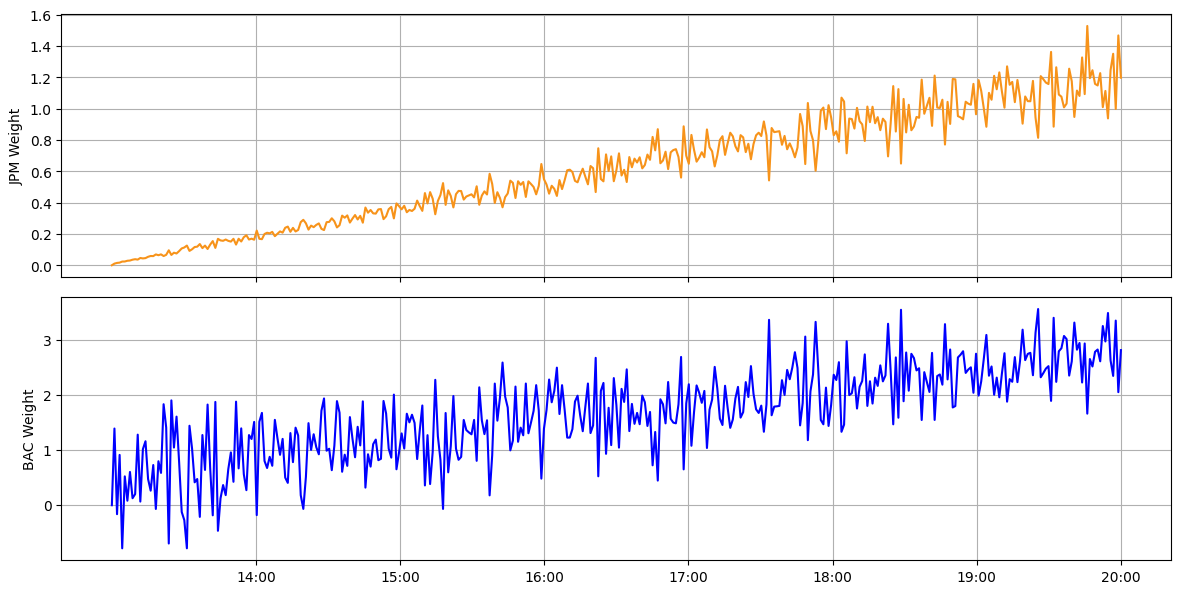

In [115]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Top chart: Closing Prices
ax1.plot(tt, pi_1, label='Mid Price', color='#f7931a')
ax1.set_ylabel('JPM Weight')
ax1.grid(True)


# Bottom chart: Returns
ax2.plot(tt, pi_2, label='Minutely Returns', color='b')
ax2.set_ylabel('BAC Weight')
ax2.grid(True)  # Set grid on both major and minor tick marks

# Adjusting the layout
plt.tight_layout()
ax1.set_xticks([0, 0.125, 0.250, 0.375, 0.5, 0.625, 0.75, 0.875, 1])
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.xticks(ticks = [ 0.1428571429, 0.1428571429*2, 0.1428571429*3, 0.1428571429*4, 0.1428571429*5, 0.1428571429*6, 0.1428571429*7], labels=['14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00'])

# Show plot
plt.show()

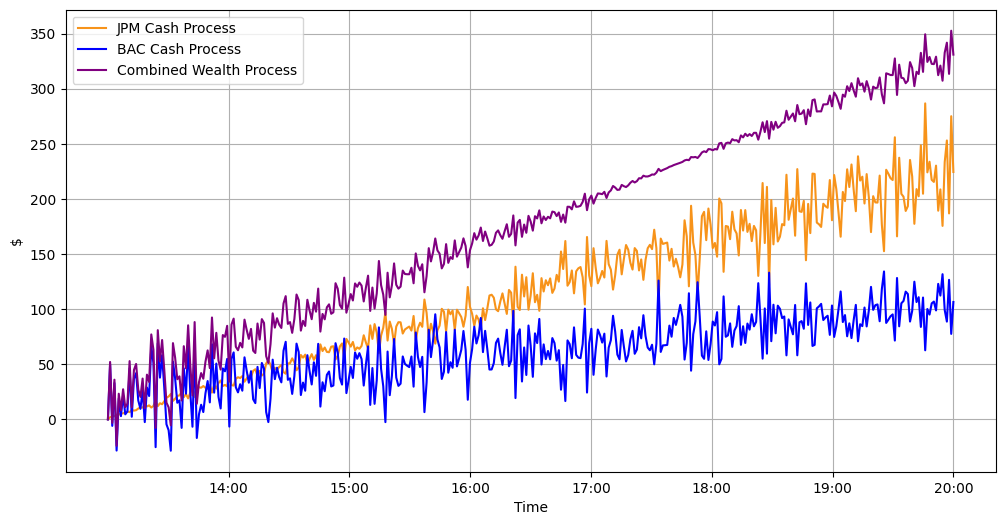

In [118]:
plt.figure(figsize=(12, 6))
plt.plot(tt, pi_1 * S1, '#f7931a', lw=1.5, label='JPM Cash Process')
plt.plot(tt, pi_2 * S2, 'b', lw=1.5, label='BAC Cash Process')
plt.plot(tt, pi_1 * S1 + pi_2 * S2, 'purple', lw=1.5, label='Combined Wealth Process')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('$')

plt.xticks(ticks = [ 0.1428571429, 0.1428571429*2, 0.1428571429*3, 0.1428571429*4, 0.1428571429*5, 0.1428571429*6, 0.1428571429*7], labels=['14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00'])

plt.grid(True)
plt.show()

JPM Weight: 0.6177, BAC Weight: 1.6650


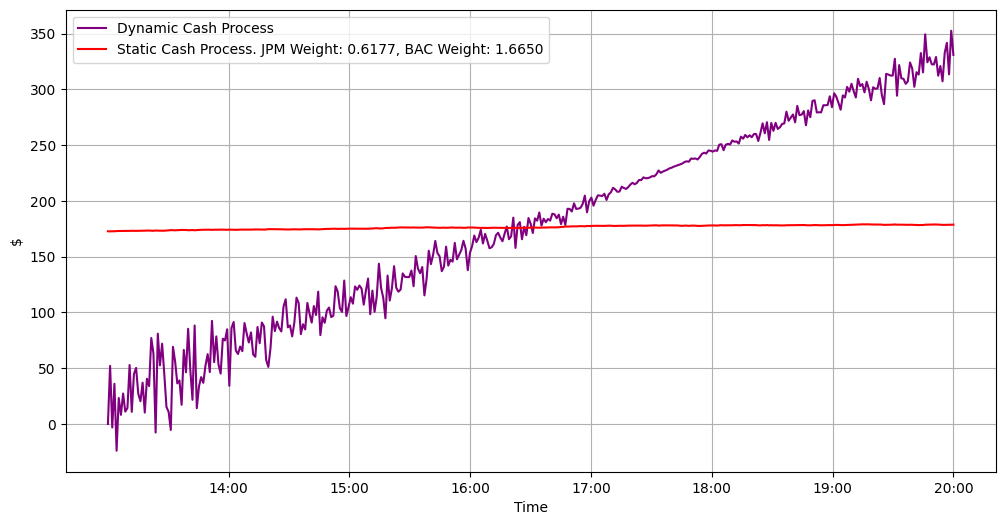

In [119]:
print(f'JPM Weight: {pi_1.mean():.4f}, BAC Weight: {pi_2.mean():.4f}')

plt.figure(figsize=(12, 6))
plt.plot(tt, pi_1 * S1 + pi_2 * S2, 'purple', lw=1.5, label='Dynamic Cash Process')
plt.plot(tt, pi_1.mean() * S1 + pi_2.mean() * S2, 'r', lw=1.5, label=f'Static Cash Process. JPM Weight: {pi_1.mean():.4f}, BAC Weight: {pi_2.mean():.4f}')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('$')
plt.xticks(ticks = [ 0.1428571429, 0.1428571429*2, 0.1428571429*3, 0.1428571429*4, 0.1428571429*5, 0.1428571429*6, 0.1428571429*7], labels=['14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00'])
plt.grid(True)